# AIHI_ IMDB250_ Clustering
We aim to find the __top 250 ranked movies__ from IMDB data and cluster them according to similar movies based on all the data columns we can retrieve

In [1]:
# import urllib2
from bs4 import BeautifulSoup
import requests
from requests import get
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt
import string
from matplotlib import pyplot as plt
sns.set(style="ticks")

import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet as wn


pd.set_option('display.notebook_repr_html', True)
sns.set(style="ticks")
%matplotlib inline


import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster') 

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\envs\myclone\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\myclone\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\myclone\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import numpy as np

np.random.seed(42)

## Scrapping `movie ids` of the top 250 movies
The First part will be to collect all the imdb ids of the top 250 movies. We have done this by scrapping imdb's webpage.

In [205]:
url='http://www.imdb.com/chart/top'
page=get(url).content
soup=BeautifulSoup(page,'html.parser')
class_=soup.find_all(name='div',attrs={'class':'wlb_ribbon'})
movie_ids=[c['data-tconst'] for c in class_]

The movie_ids is a list of the top 250 movie ids of imdb.

We will be using omdb for data collection. The data will be collected from omdb's api.

In [206]:
len(movie_ids)

250

In [207]:
movie_info=[[] for i in range(len(movie_ids))]

# some online source provided the freeAPIkey when they subscribe as a patron
for i in range(250):
    url='http://www.omdbapi.com/?i='
    r=requests.get(url+movie_ids[i]+"&apikey=de12b217").json()
    for a in r.keys():
        movie_info[i].append(r[a])
        
df_omdb=pd.DataFrame(movie_info,columns=r.keys())

In [208]:
df_omdb.columns

Index(['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 'Writer', 'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Poster', 'Ratings', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID', 'Type', 'DVD', 'BoxOffice', 'Production', 'Website', 'Response'], dtype='object')

In [209]:
df_omdb.Poster[0]

'https://m.media-amazon.com/images/M/MV5BMDFkYTc0MGEtZmNhMC00ZDIzLWFmNTEtODM1ZmRlYWMwMWFmXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_SX300.jpg'

In [210]:
df_omdb['Plot'][0]

'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.'

In [211]:
len(df_omdb)

250

Now we have collected all of the information from the omdb database. To get a more richer dataset (the description) of movies we will now try to get the database from imdb. Now we use the `BeautifulSoup` package to scrape web data.

In [212]:
url='http://www.imdb.com/title/'
t='/plotsummary?ref_=tt_stry_pl'
plot=[[] for i in range(len(movie_ids))]
for i in range(250):
    page=get(url+df_omdb.imdbID[i]+t).content
    soup=BeautifulSoup(page,'html.parser')
    class_=soup.find_all(name='li',attrs={'class':'ipl-zebra-list__item'})
    for j in class_:
        plot[i].append(j.get_text(strip = True))

In [213]:
df_omdb['Plot']=plot
df_omdb.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
0,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,Drama,Frank Darabont,"Stephen King, Frank Darabont","Tim Robbins, Morgan Freeman, Bob Gunton",[Two imprisoned men bond over a number of year...,English,United States,Nominated for 7 Oscars. 21 wins & 43 nominatio...,https://m.media-amazon.com/images/M/MV5BMDFkYT...,"[{'Source': 'Internet Movie Database', 'Value'...",80,9.3,"2,523,987",tt0111161,movie,21 Dec 1999,"$28,699,976",N/A,N/A,True
1,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola","Marlon Brando, Al Pacino, James Caan",[The aging patriarch of an organized crime dyn...,"English, Italian, Latin",United States,Won 3 Oscars. 31 wins & 30 nominations total,https://m.media-amazon.com/images/M/MV5BM2MyNj...,"[{'Source': 'Internet Movie Database', 'Value'...",100,9.2,"1,742,506",tt0068646,movie,11 May 2004,"$134,966,411",N/A,N/A,True
2,The Godfather: Part II,1974,R,18 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola, Mario Puzo","Al Pacino, Robert De Niro, Robert Duvall",[The early life and career of Vito Corleone in...,"English, Italian, Spanish, Latin, Sicilian",United States,Won 6 Oscars. 17 wins & 20 nominations total,https://m.media-amazon.com/images/M/MV5BMWMwMG...,"[{'Source': 'Internet Movie Database', 'Value'...",90,9.0,"1,208,928",tt0071562,movie,24 May 2005,"$47,834,595",N/A,N/A,True
3,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama",Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer","Christian Bale, Heath Ledger, Aaron Eckhart",[When the menace known as the Joker wreaks hav...,"English, Mandarin","United States, United Kingdom",Won 2 Oscars. 159 wins & 163 nominations total,https://m.media-amazon.com/images/M/MV5BMTMxNT...,"[{'Source': 'Internet Movie Database', 'Value'...",84,9.0,"2,480,928",tt0468569,movie,09 Dec 2008,"$534,858,444",N/A,N/A,True
4,12 Angry Men,1957,Approved,10 Apr 1957,96 min,"Crime, Drama",Sidney Lumet,Reginald Rose,"Henry Fonda, Lee J. Cobb, Martin Balsam",[The jury in a New York City murder trial is f...,English,United States,Nominated for 3 Oscars. 17 wins & 13 nominatio...,https://m.media-amazon.com/images/M/MV5BMWU4N2...,"[{'Source': 'Internet Movie Database', 'Value'...",96,9.0,"745,346",tt0050083,movie,04 Mar 2008,N/A,N/A,N/A,True


In [214]:
df_omdb['Plot'].loc[0]

['Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 "Chronicles the experiences of a formerly successful banker as a prisoner in the gloomy jailhouse of Shawshank after being found guilty of a crime he did not commit. The film portrays the man's unique way of dealing with his new, torturous life; along the way he befriends a number of fellow prisoners, most notably a wise long-term inmate named Red.—J-S-Golden",
 'After the murder of his wife, hotshot banker Andrew Dufresne is sent to Shawshank Prison, where the usual unpleasantness occurs. Over the years, he retains hope and eventually gains the respect of his fellow inmates, especially longtime convict "Red" Redding, a black marketeer, and becomes influential within the prison. Eventually, Andrew achieves his ends on his own terms.—Reid Gagle',
 "Andy Dufresne is sent to Shawshank Prison for the murder of his wife and her secret lover. He is very isolated and lon

Add the link to where we can use the movieId to locate the IMDB website of the movie trailer

In [215]:
# add imdb website link to the db_omdb
imdb_link = []
for item in df_omdb.imdbID:
    imdb_link.append(f"https://www.imdb.com/title/{item}")
df_omdb['imdb_link'] = imdb_link
# top 250 movies
df_omdb.to_csv("top250.csv", index = False)

In [129]:
# convert "Year" column to numeric
df_omdb["Year"] = pd.to_numeric(df_omdb["Year"], downcast ="integer")
# sort the dataframe by the order of "Year"
df_omdb = df_omdb.sort_values(by = 'Year', ascending = True)
df_omdb

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
103,The Kid,1921,Passed,06 Feb 1921,68 min,"Comedy, Drama, Family",Charles Chaplin,Charles Chaplin,"Charles Chaplin, Edna Purviance, Jackie Coogan","[The Tramp cares for an abandoned child, but e...",English,United States,2 wins,https://m.media-amazon.com/images/M/MV5BZjhhMT...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,8.3,"122,576",tt0012349,movie,01 May 2005,N/A,N/A,N/A,True
191,Sherlock Jr.,1924,Passed,11 May 1924,45 min,"Action, Comedy, Romance",Buster Keaton,"Jean C. Havez, Joseph A. Mitchell, Clyde Bruckman","Buster Keaton, Kathryn McGuire, Joe Keaton","[A film projectionist longs to be a detective,...","None, English",United States,1 win,https://m.media-amazon.com/images/M/MV5BZWFhOG...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,8.2,"47,343",tt0015324,movie,11 Dec 2012,"$977,375",N/A,N/A,True
159,The Gold Rush,1925,Passed,13 Jul 1925,95 min,"Adventure, Comedy, Drama",Charles Chaplin,Charles Chaplin,"Charles Chaplin, Mack Swain, Tom Murray",[A prospector goes to the Klondike during the ...,English,United States,Nominated for 2 Oscars. 3 wins & 3 nominations...,https://m.media-amazon.com/images/M/MV5BZjEyOT...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,8.2,"108,185",tt0015864,movie,12 Jun 2012,N/A,N/A,N/A,True
188,The General,1926,Passed,02 Jan 1927,67 min,"Action, Adventure, Comedy","Clyde Bruckman, Buster Keaton","Buster Keaton, Clyde Bruckman, Al Boasberg","Buster Keaton, Marion Mack, Glen Cavender",[After being rejected by the Confederate milit...,English,United States,2 wins & 1 nomination,https://m.media-amazon.com/images/M/MV5BYmRiMD...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,8.1,"88,428",tt0017925,movie,22 Mar 2007,N/A,N/A,N/A,True
109,Metropolis,1927,Not Rated,13 Mar 1927,153 min,"Drama, Sci-Fi",Fritz Lang,"Thea von Harbou, Fritz Lang","Brigitte Helm, Alfred Abel, Gustav Fröhlich",[In a futuristic city sharply divided between ...,"German, English",Germany,6 wins & 6 nominations,https://m.media-amazon.com/images/M/MV5BMTg5YW...,"[{'Source': 'Internet Movie Database', 'Value'...",98,8.3,"169,123",tt0017136,movie,22 Mar 2007,"$1,236,166",N/A,N/A,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,Demon Slayer: Mugen Train,2020,R,23 Apr 2021,117 min,"Animation, Action, Adventure",Haruo Sotozaki,Koyoharu Gotouge,"Natsuki Hanae, Akari Kitô, Yoshitsugu Matsuoka",[After his family was brutally murdered and hi...,Japanese,Japan,4 wins & 3 nominations,https://m.media-amazon.com/images/M/MV5BODI2Nj...,"[{'Source': 'Internet Movie Database', 'Value'...",75,8.2,"44,469",tt11032374,movie,N/A,"$49,505,008",N/A,N/A,True
86,Hamilton,2020,PG-13,03 Jul 2020,160 min,"Biography, Drama, History",Thomas Kail,"Lin-Manuel Miranda, Ron Chernow","Lin-Manuel Miranda, Phillipa Soo, Leslie Odom Jr.",[The real life of one of America's foremost fo...,English,United States,Won 1 Primetime Emmy. 17 wins & 46 nominations...,https://m.media-amazon.com/images/M/MV5BNjViNW...,"[{'Source': 'Internet Movie Database', 'Value'...",90,8.4,"81,457",tt8503618,movie,03 Jul 2020,N/A,N/A,N/A,True
137,Jai Bhim,2021,TV-MA,02 Nov 2021,164 min,"Crime, Drama",T.J. Gnanavel,T.J. Gnanavel,"Suriya, Lijo Mol Jose, Manikandan",[When a tribal man is arrested for a case of a...,"Tamil, Hindi",India,3 wins,https://m.media-amazon.com/images/M/MV5BY2Y5ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,9.3,"172,126",tt15097216,movie,N/A,N/A,N/A,N/A,True
202,Dune,2021,PG-13,22 Oct 2021,155 min,"Action, Adventure, Drama",Denis Villeneuve,"Jon Spaihts, Denis Villeneuve, Eric Roth","Timothée Chalamet, Rebecca Ferguson, Zendaya",[Feature adaptation of Frank Herbert's science...,"English, Mandarin","United States, Canada",64 wins & 204 nominations,https://m.media-ama

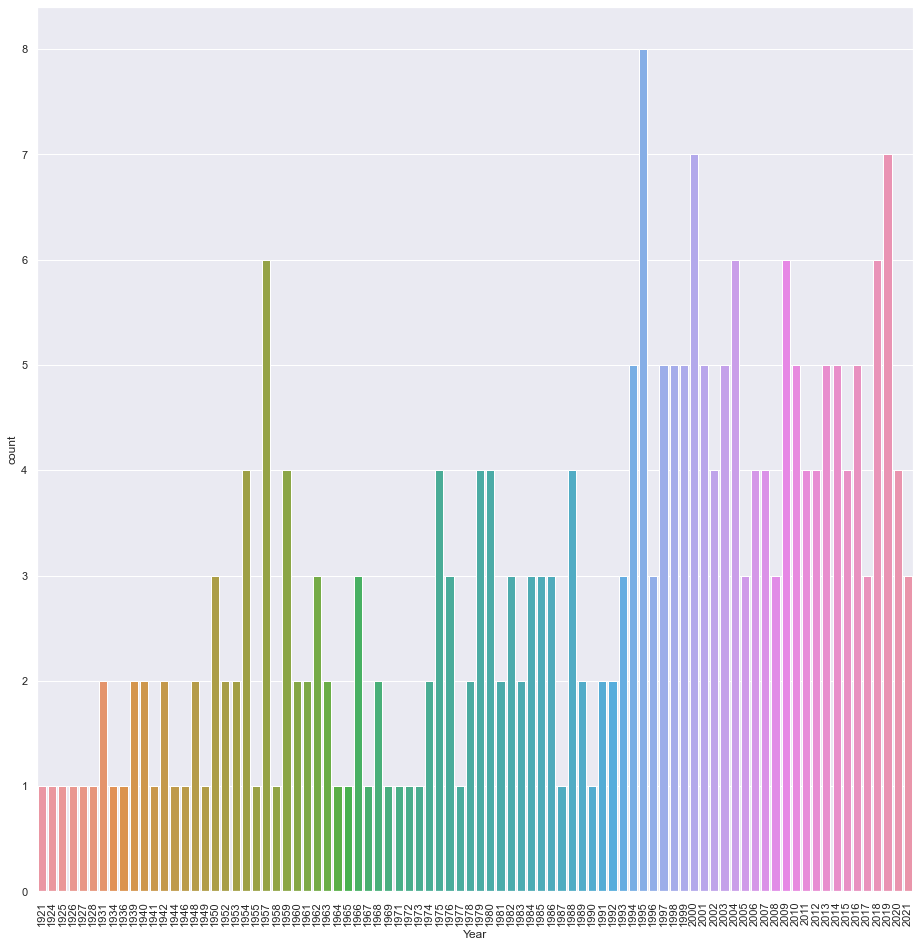

In [130]:
# importing the required library
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(15.7,16.27)})
  
# who v/s fare barplot
sns.countplot(x = 'Year',
            data = df_omdb)

# rotate x labels
plt.xticks(rotation=90)

 
# Show the plot
plt.show()

## Cleaning the dataset


In [131]:
list(df_omdb.columns)

['Title',
 'Year',
 'Rated',
 'Released',
 'Runtime',
 'Genre',
 'Director',
 'Writer',
 'Actors',
 'Plot',
 'Language',
 'Country',
 'Awards',
 'Poster',
 'Ratings',
 'Metascore',
 'imdbRating',
 'imdbVotes',
 'imdbID',
 'Type',
 'DVD',
 'BoxOffice',
 'Production',
 'Website',
 'Response']

In [132]:
# median of column "Year"
medians=df_omdb["Year"].median()
print("medians of 'Year' Column:")
print(medians)

medians of 'Year' Column:
1995.0


First step in cleaning the data is to convert Year to a categorical variable. Year 1994 was chosen as a suitable cutoff since it is the `median`. Movies released before 1994 became 0 and after 1994 became 1. After doing this we performed one hot encoding and added dummy variables of Year(now 0,1) in the dataframe.

In [133]:
df_omdb.Year=pd.to_numeric(df_omdb.Year)
for i in range(250):
    if df_omdb.Year[i]<1995:
        df_omdb.Year[i]=0
    else:
        df_omdb.Year[i]=1
dummy_year=pd.get_dummies(df_omdb.Year)

for i in range(250):
    df_omdb.Runtime[i]=df_omdb.Runtime[i].split()[0]

Next step is to convert Runtime to a categorical variable. A Runtime of 125 mins was chosen as a suitable cutoff because it was the median value all datapoints. Movies having a runtime less than 125 mins became 0 and greater than 125 mins became 1

In [134]:
# Find the median of the column "runtime"
df_omdb.Runtime

103     68
191     45
159     95
188     67
109    153
      ... 
239    117
86     160
137    164
202    155
27     148
Name: Runtime, Length: 250, dtype: object

In [135]:
# find median of the column "runtime"
medians=df_omdb["Runtime"].median()
print("medians of 'Runtime' Column:")
print(medians)

# Create categorical variable with value 0 for Runtime < median, and value 1 otherwise
df_omdb['Runtime']=pd.to_numeric(df_omdb['Runtime'],errors='coerce')
for i in range(250):
    if df_omdb.Runtime[i]<=medians:
        df_omdb.Runtime[i]=0
    else: 
        df_omdb.Runtime[i]=1

medians of 'Runtime' Column:
127.5


In [136]:
## Other useful handy functions
def clean(column_name):
    """This function takes a column from the dataframe and splits two elements
       if they are separated by a comma.
       For ex. in Actors column there might be values such as Christian Bale, Morgan Freeman.
       This will separate these two actors and store them individually in a list.
       
       Args:
           column_name (list) : the column name of a df
       Returns:
           name(set) : set of sorted elements
       """
    name=set()
    for name_string in df_omdb[column_name]:
        name.update(name_string.split(', '))
    name=sorted(name)
    return name

def top(column_name):
    """This function takes its input as name of the column and returns a sorted list of the 
       elements which occur very frequently in that column in descending order.
       Args:
           column_name (list) : the column name of a df
       Returns:
           nlt.index (list)
       """
    
    name=clean(column_name)
    dummy_name=pd.DataFrame()
    for n in name:
        dummy_name[n]=[int(n in nm.split(', ')) for nm in df_omdb[column_name]] 
    
    namelist=[n for n in name]
    nlt=dummy_name[namelist].sum()
    nlt=nlt.sort_values(axis=0,ascending=False)
    return nlt.index
    
def plot_column(column_name,n_elem_display=0):
    """ This function is used to plot a bar graph of a column of the dataframe.
        It takes its argument as name of column and number of elements to display and
        return a bar graph of the user defined number of top elements which occur
        frequently in that column."""
    
    name=clean(column_name)
    dummy_name=pd.DataFrame()
    for n in name:
        dummy_name[n]=[int(n in nm.split(', ')) for nm in df_omdb[column_name]] 
    
    namelist=[n for n in name]
    nlt=dummy_name[namelist].sum()
    nlt=nlt.sort_values(axis=0,ascending=False)
    if n_elem_display !=0:
        return nlt[:n_elem_display].plot(kind = "bar",figsize=(10,10))
    else:
        return nlt[:].plot(kind = "bar",figsize=(10,5))

<AxesSubplot:>

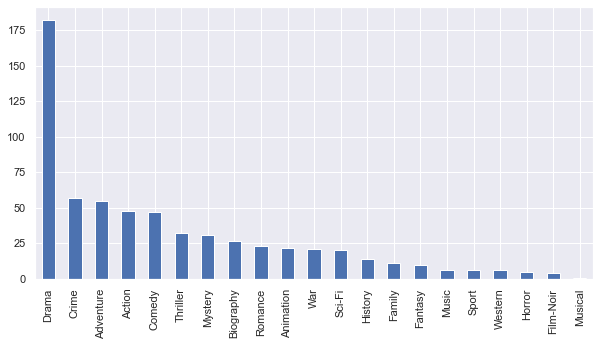

In [137]:
# plotting the barplot of `Genre`
plot_column('Genre')

<AxesSubplot:>

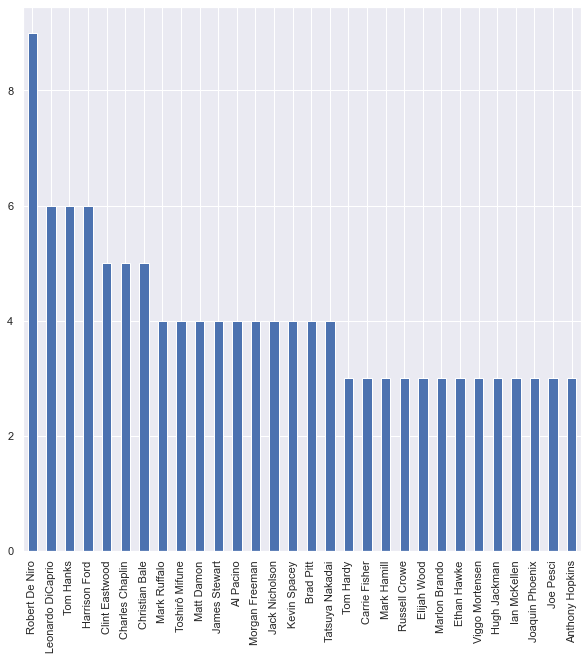

In [138]:
# Actors appeared in how many shows out of the 250 top movies, limited to top 30 actors
plot_column('Actors',30)

<AxesSubplot:>

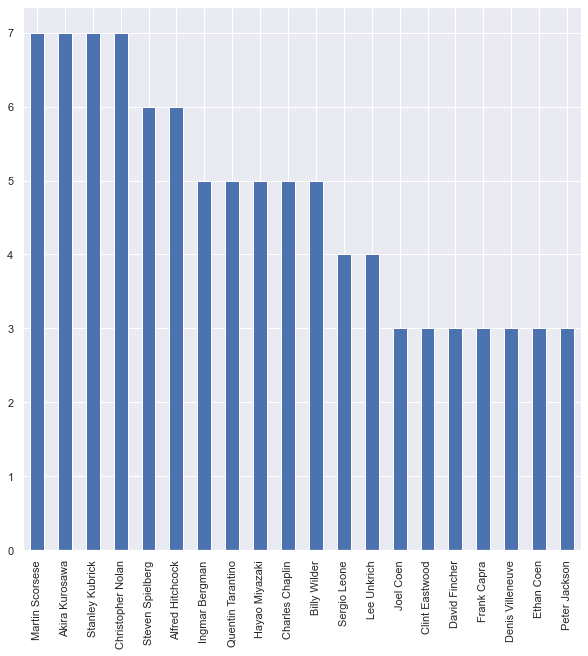

In [139]:
# Directors appeared in how many shows out of the 250 top movies, limited to top 20 directors
plot_column('Director',20)

In [140]:
df_omdb

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
103,The Kid,0,Passed,06 Feb 1921,0,"Comedy, Drama, Family",Charles Chaplin,Charles Chaplin,"Charles Chaplin, Edna Purviance, Jackie Coogan","[The Tramp cares for an abandoned child, but e...",English,United States,2 wins,https://m.media-amazon.com/images/M/MV5BZjhhMT...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,8.3,"122,576",tt0012349,movie,01 May 2005,N/A,N/A,N/A,True
191,Sherlock Jr.,0,Passed,11 May 1924,0,"Action, Comedy, Romance",Buster Keaton,"Jean C. Havez, Joseph A. Mitchell, Clyde Bruckman","Buster Keaton, Kathryn McGuire, Joe Keaton","[A film projectionist longs to be a detective,...","None, English",United States,1 win,https://m.media-amazon.com/images/M/MV5BZWFhOG...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,8.2,"47,343",tt0015324,movie,11 Dec 2012,"$977,375",N/A,N/A,True
159,The Gold Rush,0,Passed,13 Jul 1925,0,"Adventure, Comedy, Drama",Charles Chaplin,Charles Chaplin,"Charles Chaplin, Mack Swain, Tom Murray",[A prospector goes to the Klondike during the ...,English,United States,Nominated for 2 Oscars. 3 wins & 3 nominations...,https://m.media-amazon.com/images/M/MV5BZjEyOT...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,8.2,"108,185",tt0015864,movie,12 Jun 2012,N/A,N/A,N/A,True
188,The General,0,Passed,02 Jan 1927,0,"Action, Adventure, Comedy","Clyde Bruckman, Buster Keaton","Buster Keaton, Clyde Bruckman, Al Boasberg","Buster Keaton, Marion Mack, Glen Cavender",[After being rejected by the Confederate milit...,English,United States,2 wins & 1 nomination,https://m.media-amazon.com/images/M/MV5BYmRiMD...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,8.1,"88,428",tt0017925,movie,22 Mar 2007,N/A,N/A,N/A,True
109,Metropolis,0,Not Rated,13 Mar 1927,1,"Drama, Sci-Fi",Fritz Lang,"Thea von Harbou, Fritz Lang","Brigitte Helm, Alfred Abel, Gustav Fröhlich",[In a futuristic city sharply divided between ...,"German, English",Germany,6 wins & 6 nominations,https://m.media-amazon.com/images/M/MV5BMTg5YW...,"[{'Source': 'Internet Movie Database', 'Value'...",98,8.3,"169,123",tt0017136,movie,22 Mar 2007,"$1,236,166",N/A,N/A,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,Demon Slayer: Mugen Train,1,R,23 Apr 2021,0,"Animation, Action, Adventure",Haruo Sotozaki,Koyoharu Gotouge,"Natsuki Hanae, Akari Kitô, Yoshitsugu Matsuoka",[After his family was brutally murdered and hi...,Japanese,Japan,4 wins & 3 nominations,https://m.media-amazon.com/images/M/MV5BODI2Nj...,"[{'Source': 'Internet Movie Database', 'Value'...",75,8.2,"44,469",tt11032374,movie,N/A,"$49,505,008",N/A,N/A,True
86,Hamilton,1,PG-13,03 Jul 2020,1,"Biography, Drama, History",Thomas Kail,"Lin-Manuel Miranda, Ron Chernow","Lin-Manuel Miranda, Phillipa Soo, Leslie Odom Jr.",[The real life of one of America's foremost fo...,English,United States,Won 1 Primetime Emmy. 17 wins & 46 nominations...,https://m.media-amazon.com/images/M/MV5BNjViNW...,"[{'Source': 'Internet Movie Database', 'Value'...",90,8.4,"81,457",tt8503618,movie,03 Jul 2020,N/A,N/A,N/A,True
137,Jai Bhim,1,TV-MA,02 Nov 2021,1,"Crime, Drama",T.J. Gnanavel,T.J. Gnanavel,"Suriya, Lijo Mol Jose, Manikandan",[When a tribal man is arrested for a case of a...,"Tamil, Hindi",India,3 wins,https://m.media-amazon.com/images/M/MV5BY2Y5ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",N/A,9.3,"172,126",tt15097216,movie,N/A,N/A,N/A,N/A,True
202,Dune,1,PG-13,22 Oct 2021,1,"Action, Adventure, Drama",Denis Villeneuve,"Jon Spaihts, Denis Villeneuve, Eric Roth","Timothée Chalamet, Rebecca Ferguson, Zendaya",[Feature adaptation of Frank Herbert's science...,"English, Mandarin","United States, Canada",64 wins & 204 nominations,https://m.media-amazon.com/images/M/MV5BN2FjNm...,"[{'Source': 'Internet Movie Database', 'Value

In [141]:
# making sum of each `Genre` as a feature column
#Get the unique genres contained in the dataframe
genres=clean('Genre')
#Add one column for every genre in the dataframe
for genre in genres:
    df_omdb["genre:"+genre] = [int(genre in g.split(', ')) for g in df_omdb.Genre]
    
# making sum of each `Actor` as a feature column
# taking top 30 actors with having more than 3 movies in the top 250 movies of imdb
#Adding actors to our dataset
actors=top('Actors')
actors
for actor in actors[:30]:
    df_omdb["Actor:"+actor] = [int(actor in a.split(', ')) for a in df_omdb.Actors]
    
# making sum of each `Director` as a feature column
# taking top 20 directors with having more than 2 movies in the top 250 movies of IMDB
directors=top('Director')
    
for director in directors[:20]:
    df_omdb["Director:"+director] = [int(director in d.split(', ')) for d in df_omdb.Director]    

Because i need to display some output of possible selection for user to type in chatbot, we need to get them in dataframe and then display on the output of chatbot

In [216]:
# make a "genre" dataframe and keep
genres=clean('Genre')
df_genres = pd.DataFrame(genres, columns = ['genres'])
df_genres.to_csv("genre_list250.csv", index = False)

# make a "Language" dataframe and keep
language=clean('Language')
df_language = pd.DataFrame(language, columns = ['language'])
df_language.to_csv("language_list250.csv", index = False)

In [142]:
writers1=set()
writers2=set()
for writer_string in df_omdb.Writer:
    writers1.update(writer_string.split(', '))
for j in writers1:
    writers2.update(j.rsplit(' (')[:1])
writers2 = sorted(writers2)

dummy_writers=pd.DataFrame()

# Add one column for every writer in the dataframe
for writer in writers1:
    dummy_writers[writer] = [int(writer in w.split(', ')) for w in df_omdb.Writer]   
dummy_writers  

,Philippa Boyens,Cesare Zavattini,Carl Foreman,John Hodge,Kwang-rim Kim,David Reynolds,Julie Delpy,Jim Reardon,Samuel A. Taylor,Lew Wallace,Dario Argento,F.X. Toole,Éric Toledano,Jake LaMotta,Philip Kaufman,Budd Schulberg,Al Boasberg,John-Henry Butterworth,Jason Keller,Cindy Davis,James Ellroy,Lothar G. Buchheim,Paul Thomas Anderson,Winston Groom,Dave Johannson,Joseph Carter,Stan Lee,Valérie Beaugrand-Champagne,Fritz Lang,Dennis Lehane,Shalini Ushadevi,Nick Lathouris,Joachim Fest,Jeff Pidgeon,John Ridley,Ingmar Bergman,Jeethu Joseph,Louis Garfinkle,Joseph Delteil,Fulvio Morsella,Agatha Christie,Ryûnosuke Akutagawa,Boris Strugatskiy,Neeraj Vora,Stephen McFeely,Michael Cimino,Bibhutibhushan Bandyopadhyay,George Lucas,Kaneto Shindô,Neil Gaiman,...,Makoto Shinkai,Tom McCarthy,Robert Zemeckis,J.K. Rowling,Nikhil Mehrotra,Todd Phillips,Adam Elliot,Christopher Priest,Ben Affleck,Quentin Tarantino,Howard Koch,Peter Shaffer,Shreyas Jain,David Giler,Alan Ball,Yasujirô Ozu,Malcolm Johnson,Jean C. Havez,Koyoharu Gotouge,C. Prem Kumar,Sergio Leone,Bob Peterson,Joel Coen,Michael Wilson,Chris Sanders,Sylvester Stallone,Mario Puzo,David Lynch,Park Chan-wook,Lal,Jin-won Han,Paul Brickhill,Thomas Keneally,Yuriy Nagibin,D.M. Marshman Jr.,Darren Aronofsky,Bruce A. Evans,Eduardo Sacheri,Ronald Shusett,Michael Green,Brian Hayes Currie,Dan O'Bannon,Clark Cheng,John Michael Hayes,Charles Chaplin,W.R. Burnett,Jill Culton,Anthony Tambakis,Akiyuki Nosaka,Graham Chapman
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
246,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Sinced the `dummy_writers` dataframe is very sparse, and likely not able to give any useful information to the clustering algorithm, we will drop `Writer` column from our feature data.  

We will drop the `Language` column as most of the movies are in English  

We will take the top 10 `Country`

<AxesSubplot:>

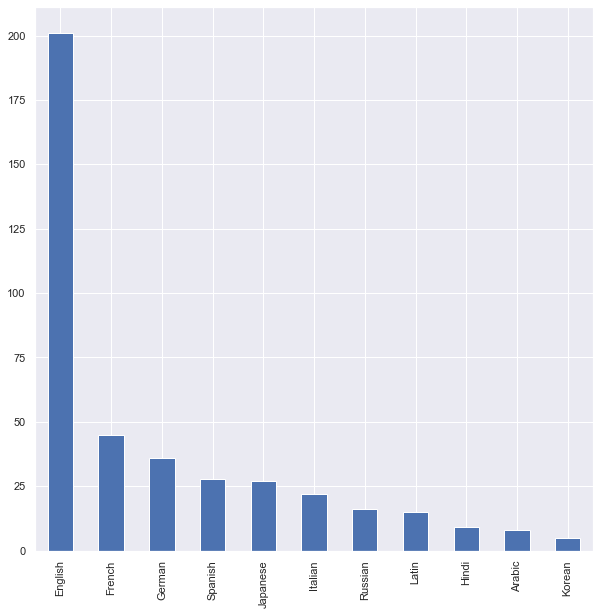

In [143]:
plot_column('Language',11)

<AxesSubplot:>

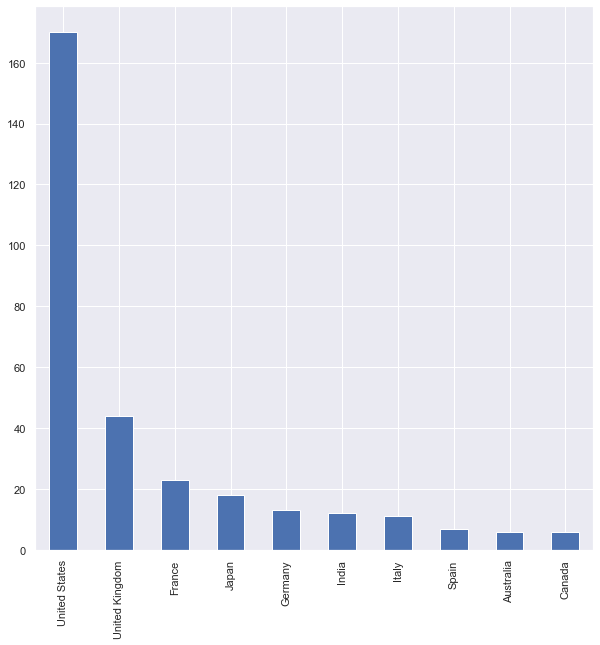

In [144]:
plot_column('Country',10)

In [145]:
#Adding all of the top 10 countries to our datset as features
countries=top('Country')

for country in countries[:10]:
    df_omdb["Country:"+country] = [int(country in c.split(', ')) for c in df_omdb.Country]

## Dropping the columns already decided
1) `Writer`  
2) `Language`

In [146]:
df_omdb.drop(columns=['Writer','Language'], axis=1 , inplace = True)

## Process Words in "Plot" for Clustering
In the next stage we will first clean and tokenize the plot of every movie and try to extract words which can be used as features in our clustering algorithm.

In [147]:
## Function for text cleaning,tokenizing,lemmatizing and POS Tagging

def my_analyzer(s):
# Synonym List
    syns = {'wont':'would not', 'cant':'can not', 'cannot':'can not', \
    'couldnt':'could not', 'shouldnt':'should not', \
    'wouldnt':'would not', 'straightforward': 'straight forward' }
    # Preprocess String s
    s = s.lower()
    #Replace special characters with spaces
    s = s.replace('-', ' ')
    s = s.replace('_', ' ')
    s = s.replace(',', '. ')
    s = s.replace('\\',"")
    s = s.replace('.',"")

    # Replace not contraction with not
    s = s.replace("'nt", " not")
    s = s.replace("n't", " not")

    # Tokenize
    tokens = word_tokenize(s)

    #tokens = [word.replace(',','') for word in tokens ]

    tokens = [word for word in tokens if ('*' not in word) and \
    ("''" != word) and ("``" != word) and \
    (word!='description') and (word !='dtype') \
    and (word != 'object') and (word!="'s")]

    # Map synonyms
    for i in range(len(tokens)):
        if tokens[i] in syns:
            tokens[i] = syns[tokens[i]]

    # Remove stop words
    punctuation = list(string.punctuation)+['..', '...']
    pronouns = ['i', 'he', 'she', 'it', 'him', 'they', 'we', 'us', 'them','he ']
    others = ["'d", "co", "ed", "put", "say", "get", "can", "become",\
            "los", "sta", "la", "use","ask" "iii", "else","doesn't","dr.","well","let","soon","finally","around","little",\
              "would","set","use","place","still","three","arrive","next","anoth","keep","must","mr.","bring",\
              "much","many","eventually","explain","asks","along","may","small","hold","realize","think","continue",\
             "last","behind","discover","something","several","end","large","high","mr","the","dr","mr"]
    names = ["harry","travis","tommy","joe","jack","dorothy","mike","george","frank","frankie",\
            "frank ","sarah","andrew","taylor","arthur","luke","kane","wallace","parker","danny","tony",\
            "michael","luke","kane","danny","john","max","tom","paul","ca","neil","maria","barry","anna","jerry",\
            "alex","terry","henry","gordon","leonard","wayne","vincent","jimmy","jordan","sam","nick","nicholson",\
            "jake","rocky"]

    stop = stopwords.words('english') + punctuation + pronouns + others + names
    filtered_terms = [word for word in tokens if (word not in stop) and \
    (len(word)>1) and (not word.replace('.','',1).isnumeric()) \
    and (not word.replace("'",'',2).isnumeric())]

    # Lemmatization & Stemming - Stemming with WordNet POS
    # Since lemmatization requires POS need to set POS
    tagged_words = pos_tag(filtered_terms, lang='eng')

    # Stemming with for terms without WordNet POS
    stemmer = SnowballStemmer("english")
    wn_tags = {'N':wn.NOUN, 'J':wn.ADJ, 'V':wn.VERB, 'R':wn.ADV}
    wnl = WordNetLemmatizer()
    stemmed_tokens = []
    for tagged_token in tagged_words:
        term = tagged_token[0]
        pos = tagged_token[1]
        pos = pos[0]
        try:
            pos = wn_tags[pos]
            stemmed_tokens.append(wnl.lemmatize(term, pos=pos))
        except:
            stemmed_tokens.append(stemmer.stem(term))
    return stemmed_tokens

In [148]:
n_plots = len(df_omdb['Plot']) # Number of Plots
s_words = 'english' # Stop Word Dictionary
ngram = (1,3) # n-gram POS modeling
plots = df_omdb['Plot'].map(str) # place all text reviews in reviews
tfidf=True

In [149]:
plots

103    ['The Tramp cares for an abandoned child, but ...
191    ["A film projectionist longs to be a detective...
159    ['A prospector goes to the Klondike during the...
188    ['After being rejected by the Confederate mili...
109    ["In a futuristic city sharply divided between...
                             ...                        
239    ["After his family was brutally murdered and h...
86     ["The real life of one of America's foremost f...
137    ['When a tribal man is arrested for a case of ...
202    ["Feature adaptation of Frank Herbert's scienc...
27     ["With Spider-Man's identity now revealed, Pet...
Name: Plot, Length: 250, dtype: object

In [150]:
# Create Word Frequency by Review Matrix using Custom Analyzer
cv = CountVectorizer(max_df=0.9, min_df=3, max_features=None ,\
analyzer=my_analyzer, ngram_range=ngram)
tf1 = cv.fit_transform(plots)
terms1 = cv.get_feature_names()
term_sums = tf1.sum(axis=0)
term_counts = []
out1 = []
out2 = []
for i in range(len(terms1)):
    term_counts.append([terms1[i], term_sums[0,i]])
def sortSecond(e):
    return e[1]
term_counts.sort(key=sortSecond, reverse=True)
print("\nTerms with Highest Frequency:")
for i in range(400):
    print('{:<15s}{:>5d}'.format(term_counts[i][0], term_counts[i][1]))
    out1.append([term_counts[i][0], term_counts[i][1]])
np.savetxt("frequency_100.csv", out1, delimiter=",", fmt='%s')
print("")


Terms with Highest Frequency:
tell            2071
go              1821
find            1684
see             1314
back            1303
leave           1284
make            1207
man             1172
say             1056
time            1036
two             1020
try              986
kill             983
give             966
come             928
life             880
know             851
call             793
men              786
new              746
get              741
father           737
look             726
begin            709
day              708
work             705
year             702
return           686
meet             685
want             683
room             680
away             667
name             659
home             638
also             633
run              632
help             623
car              614
old              591
police           582
way              575
family           555
head             554
like             554
first            547
however          547
you

## TF-IDF find important words
TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify words in a set of documents. We generally compute a score for each word to signify its importance in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.

Reference: https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089#:~:text=TF%2DIDF%20stands%20for%20%E2%80%9CTerm,Information%20Retrieval%20and%20Text%20Mining.

In [151]:
# if tfidf is requested, replace tf matrix with frequencies weighted by IDF
if tfidf == True:
    # Construct the TF/IDF matrix from the data
    print("Conducting Term/Frequency Matrix using TF-IDF")
    tfidf_vect = TfidfVectorizer(max_df=0.7, min_df=5, \
    max_features=None,\
    analyzer=my_analyzer, ngram_range=ngram)
    tf = tfidf_vect.fit_transform(plots)
    terms = tfidf_vect.get_feature_names()
    term_idf_sums = tf.sum(axis=0)
    term_idf_scores = []
    for i in range(len(terms)):
        term_idf_scores.append([terms[i], term_idf_sums[0,i]])
    print("The Term/Frequency matrix has", tf.shape[0], " rows, and",\
        tf.shape[1], " columns.")
    print("The Term list has", len(terms), " terms.")
    term_idf_scores.sort(key=sortSecond, reverse=True)
    print("\nTerms with Highest TF-IDF Scores:")
    top_words = []
    for i in range(100):
        print('{:<15s}{:>8.2f}'.format(term_idf_scores[i][0], \
        term_idf_scores[i][1]))
        out2.append([term_idf_scores[i][0], term_idf_scores[i][1]])
        # save the top words to an excel
        np.savetxt("tfidf1_100.csv", out2, delimiter=",", fmt='%s')
        # append Top words
        top_words.append(term_idf_scores[i][0])
        
        

Conducting Term/Frequency Matrix using TF-IDF
The Term/Frequency matrix has 250  rows, and 5284  columns.
The Term list has 5284  terms.

Terms with Highest TF-IDF Scores:
father             7.15
kill               6.90
family             6.24
police             6.09
say                5.92
men                5.69
child              5.28
son                5.20
car                5.07
old                5.01
mother             4.96
wife               4.87
friend             4.84
money              4.78
young              4.74
room               4.71
name               4.65
boy                4.58
war                4.58
woman              4.43
love               4.27
live               4.23
house              4.20
train              4.20
school             4.19
murder             4.18
run                4.14
german             4.10
night              3.97
fight              3.95
world              3.93
girl               3.84
brother            3.81
film               3.72
death       

In [152]:
## Creating a dataframe of all frequent words from count_vectorizer
k = tf1.todense()
freq = pd.DataFrame(k,columns = terms1)
freq_words = freq.sum(axis = 0)
freq = freq.append(freq_words,ignore_index = True)

In [153]:
## Transposing and rearranging
freq.t = freq.T
freq.t = freq.t.reset_index()
freq.t = freq.t.drop(['index'],axis = 1)
freq.t.index = terms1
freq.t.columns.values[250] = "freq_sum"
freq.t = freq.t.sort_values("freq_sum",ascending = False)

In [154]:
freq.t

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,freq_sum
tell,0,0,3,3,11,1,2,1,0,1,1,16,3,1,5,1,2,4,7,6,1,40,11,5,2,0,7,4,6,45,5,15,2,0,12,0,2,0,1,1,7,2,22,18,4,13,1,0,12,0,...,16,4,2,2,27,0,14,0,8,14,4,27,17,21,0,16,7,11,0,81,54,0,15,34,8,2,5,11,0,1,0,3,6,11,5,0,2,9,3,8,11,3,7,1,0,5,6,4,0,2071
go,1,1,4,7,9,0,1,2,1,1,1,13,1,0,6,2,5,7,24,2,6,27,7,3,3,1,4,10,14,17,11,19,3,1,9,5,1,0,6,0,13,2,22,10,3,19,1,1,11,2,...,5,8,1,2,25,0,6,2,7,26,3,14,28,20,0,7,4,10,2,23,22,0,17,23,2,2,18,8,0,0,0,1,17,20,4,0,7,5,5,6,11,1,0,0,0,2,3,2,6,1821
find,2,5,9,5,10,1,11,5,5,2,1,10,4,1,5,3,2,1,4,5,6,10,4,2,3,4,6,2,6,7,9,14,4,1,4,3,1,2,3,5,3,0,18,8,10,7,1,0,3,1,...,5,10,0,5,21,1,16,0,2,18,5,6,22,18,1,20,0,3,8,12,4,1,11,9,0,0,7,12,7,1,0,4,8,17,2,0,7,8,3,2,14,3,1,0,0,1,8,5,5,1684
see,0,3,3,12,6,2,1,4,1,2,3,8,0,2,4,2,0,2,14,6,3,20,4,4,3,1,5,9,7,16,20,3,2,0,7,6,2,0,1,0,6,2,13,2,2,14,0,1,7,0,...,9,4,1,2,21,0,11,0,4,9,13,11,11,13,0,14,3,5,1,6,17,1,21,17,4,3,3,5,2,0,0,2,5,7,7,0,0,6,2,2,10,0,2,0,0,0,0,5,0,1314
back,2,10,8,17,2,0,3,3,5,2,2,11,0,0,2,0,0,1,2,4,1,14,2,1,2,0,1,4,8,3,6,7,2,0,8,3,3,1,2,0,7,1,8,4,4,9,0,0,7,2,...,4,3,4,1,28,0,11,0,5,7,10,3,10,18,0,5,4,14,5,7,5,0,5,6,6,1,3,7,3,0,0,3,3,16,3,0,8,4,3,2,2,1,1,0,0,4,0,3,4,1303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
exterior,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
demise,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
populate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
pornography,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [155]:
terms1

["'after",
 "'an",
 "'based",
 "'during",
 "'in",
 "'it",
 "'m",
 "'re",
 "'taking",
 "'the",
 "'two",
 "'ve",
 '11th',
 '12th',
 '1920s',
 '1930s',
 '1940s',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 '1990s',
 '19th',
 '1st',
 '20th',
 '21st',
 '30th',
 '3po',
 '4th',
 '5th',
 '6th',
 '9th',
 'a1mscfupennedu',
 'aamir',
 'aback',
 'abandon',
 'abandoned',
 'abdomen',
 'abduct',
 'abducted',
 'abduction',
 'abducts',
 'ability',
 'ablaze',
 'able',
 'aboard',
 'abort',
 'abortion',
 'abraham',
 'abroad',
 'abruptly',
 'abscond',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'abstract',
 'abus',
 'abuse',
 'abused',
 'abusive',
 'abyss',
 'academy',
 'accelerate',
 'accent',
 'accept',
 'acceptable',
 'acceptance',
 'accepts',
 'access',
 'accessory',
 'accident',
 'accidental',
 'accidentally',
 'acclaim',
 'accompanies',
 'accompany',
 'accomplice',
 'accomplish',
 'accomplishment',
 'accord',
 'accost',
 'account',
 'accountable',
 'accountant',
 'accusat

In [156]:
## Taking top words from the entire dataframe
words_df = freq.t.T
top_15_words = top_words[0:15]
df = words_df[top_15_words]

df_encoded = df
df_encoded[df_encoded!=0] = 1

# see the output
df_encoded

,father,kill,family,police,say,men,child,son,car,old,mother,wife,friend,money,young
0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0
1,1,1,0,1,1,1,0,0,1,0,0,0,0,1,1
2,0,0,0,1,1,1,0,0,0,1,0,0,1,1,0
3,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1
4,1,1,1,0,1,1,1,1,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,1,1,1,0,0,0,1,1,0,0,0,1,1,0,0
247,0,1,1,1,1,1,1,0,1,0,0,1,0,0,0
248,1,1,1,0,1,1,0,1,0,1,1,1,1,0,1
249,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0


## Dropping Unnecessary Feature columns


In [157]:
# add the top words from tf-idf to the feature as feature columns
df_final2 = pd.concat([df_omdb, df_encoded], axis=1)

# drop the remaining unneeded columns
df_final2 = df_final2.drop(['Released','Genre','Director','Actors','Plot',\
                          'Country','Awards','Poster','Ratings','Metascore','imdbVotes','imdbID','Type',\
                         'DVD','BoxOffice','Production','Website','Response','Rated','imdbRating'],axis = 1)

# drop na data
df_final2.dropna(inplace=True)
print(df_final2.shape)
df_final2.head()

(250, 99)


,Title,Year,Runtime,genre:Action,genre:Adventure,genre:Animation,genre:Biography,genre:Comedy,genre:Crime,genre:Drama,genre:Family,genre:Fantasy,genre:Film-Noir,genre:History,genre:Horror,genre:Music,genre:Musical,genre:Mystery,genre:Romance,genre:Sci-Fi,genre:Sport,genre:Thriller,genre:War,genre:Western,Actor:Robert De Niro,Actor:Leonardo DiCaprio,Actor:Tom Hanks,Actor:Harrison Ford,Actor:Clint Eastwood,Actor:Charles Chaplin,Actor:Christian Bale,Actor:Mark Ruffalo,Actor:Toshirô Mifune,Actor:Matt Damon,Actor:James Stewart,Actor:Al Pacino,Actor:Morgan Freeman,Actor:Jack Nicholson,Actor:Kevin Spacey,Actor:Brad Pitt,Actor:Tatsuya Nakadai,Actor:Tom Hardy,Actor:Carrie Fisher,Actor:Mark Hamill,Actor:Russell Crowe,Actor:Elijah Wood,Actor:Marlon Brando,Actor:Ethan Hawke,Actor:Viggo Mortensen,Actor:Hugh Jackman,Actor:Ian McKellen,Actor:Joaquin Phoenix,Actor:Joe Pesci,Actor:Anthony Hopkins,Director:Martin Scorsese,Director:Akira Kurosawa,Director:Stanley Kubrick,Director:Christopher Nolan,Director:Steven Spielberg,Director:Alfred Hitchcock,Director:Ingmar Bergman,Director:Quentin Tarantino,Director:Hayao Miyazaki,Director:Charles Chaplin,Director:Billy Wilder,Director:Sergio Leone,Director:Lee Unkrich,Director:Joel Coen,Director:Clint Eastwood,Director:David Fincher,Director:Frank Capra,Director:Denis Villeneuve,Director:Ethan Coen,Director:Peter Jackson,Country:United States,Country:United Kingdom,Country:France,Country:Japan,Country:Germany,Country:India,Country:Italy,Country:Spain,Country:Australia,Country:Canada,father,kill,family,police,say,men,child,son,car,old,mother,wife,friend,money,young
0,The Shawshank Redemption,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0
1,The Godfather,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,1,1,0,0,1,0,0,0,0,1,1
2,The Godfather: Part II,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,1,0,0,0,1,0,0,1,1,0
3,The Dark Knight,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,1
4,12 Angry Men,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0,1,1,1,1,1,1,0,0,0,0,1


As you've noticed, there are 99 features (see the df_final2 shape). Put differently, each movie has 99 dimensions. Modelling such a dataset is very difficult because it has only 250 data points and 99 dimensions. To counter this we have to first perform PCA and reduce the dimension of the dataset.

## Dimension Reduction with PCA
Since the number of features in the dataset are very high, we first have to perform PCA to reduce it to a suitable number so as to avoid the curse of dimensionality.

In [158]:
# dropping the only non numeric column
df_matrix = df_final2.drop('Title',axis=1)

# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_matrix)
df_matrix=scaler.transform(df_matrix)

In [159]:
df_matrix

array([[-1.02429504,  1.        , -0.48746668, ..., -1.32183688,
        -0.86501546, -1.44444444],
       [-1.02429504,  1.        , -0.48746668, ..., -1.32183688,
         1.1560487 ,  0.69230769],
       [-1.02429504,  1.        , -0.48746668, ...,  0.756523  ,
         1.1560487 , -1.44444444],
       ...,
       [-1.02429504,  1.        , -0.48746668, ..., -1.32183688,
        -0.86501546, -1.44444444],
       [ 0.97628121,  1.        , -0.48746668, ...,  0.756523  ,
        -0.86501546,  0.69230769],
       [ 0.97628121,  1.        , -0.48746668, ..., -1.32183688,
        -0.86501546, -1.44444444]])

In [160]:
from sklearn.decomposition import PCA
pca = PCA().fit(df_matrix)

# keeping features with explained_variance_ratio > 0.01
top_PCA=["%.2f" % a for a in pca.explained_variance_ratio_ if a >=0.01]
print(len(top_PCA))
print(top_PCA)
sumall=sum(pca.explained_variance_ratio_)

38
['0.04', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01']


In [161]:
pca = PCA(n_components=len(top_PCA)).fit(df_matrix)
sums=sum(pca.explained_variance_ratio_)
print(f"Total data explained after PCA: {sums/sumall}")

Total data explained after PCA: 0.7405638501770471


First component explains the highest i.e 4% of variance in our data. We have selected those components which explain 1% or more variation in our dataset. Thus, we endup with 39 components out of 99 which explain 75.03% variation in our dataset.



We can also check which features were most important for the first principal component.

In [162]:
# which features were most important for the first principal component
first_comp = pca.components_[0]
first_comps = pd.DataFrame(list(zip(first_comp, df_final2.columns)), columns=['weights', 'features'])
first_comps['abs_weights']=first_comps['weights'].apply(lambda x: np.abs(x))
first_comps.sort_values('abs_weights', ascending=False,inplace=True)

Top_39_features=first_comps
Top_39_features

,weights,features,abs_weights
49,0.419366,Actor:Hugh Jackman,0.419366
72,0.419366,Director:Ethan Coen,0.419366
44,0.419366,Actor:Russell Crowe,0.419366
47,0.320806,Actor:Ethan Hawke,0.320806
90,-0.158935,child,0.158935
...,...,...,...
81,-0.003413,Country:Spain,0.003413
69,0.002905,Director:David Fincher,0.002905
48,0.002626,Actor:Viggo Mortensen,0.002626
55,-0.001069,Director:Akira Kurosawa,0.001069


Here we observe that `Actor: Hugh Jackman` have the highest weight and is above `Director:Ethan Coen`. We observe that Robert De Niro have also been assigned high weights among actors which makes sense because they have maximum number of movies in IMDB's Top 250.

## K Means Clustering 

In [163]:
Xpca=pca.transform(df_matrix)
Xpca

array([[ 0.21747501, -1.14708273, -0.58898647, ..., -1.03071143,
         0.95576597, -1.87632553],
       [-0.04197273, -2.48258154,  0.93944919, ..., -0.26260185,
        -0.25599626,  0.37778642],
       [ 0.46986068, -3.00443925,  0.70895294, ..., -0.18793815,
         0.58769531, -1.71509841],
       ...,
       [-0.3388936 , -1.10889705,  0.34784325, ..., -0.0932779 ,
         1.43690073, -1.67503162],
       [-1.26096406,  0.01944954,  0.36623653, ..., -0.35722936,
        -0.94829287, -0.05127595],
       [ 0.79108285, -1.41406336, -1.01723591, ..., -0.59895357,
        -0.31256141, -0.49096283]])

In [164]:
# Clustering silhouette_score
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


# store the max silouette score's number of cluster and its corresponding cluster
best_sil = 0
best_cluster = 0
# load the sklearn load_iris() dataset
X = Xpca
# show the silouette score for 2 to 10 clusters
for n_cluster in range(2, 21):    
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(
    n_cluster, sil_coeff))
    # updating the best_cluster if the silouette score is the highest
    if float(sil_coeff) > float(best_sil):
        best_sil = sil_coeff
        best_cluster = n_cluster
    else:
        pass
    
print("\n\n")
print(f"The best cluster k is at : {best_cluster}")  


For n_clusters=2, The Silhouette Coefficient is 0.432878946817467
For n_clusters=3, The Silhouette Coefficient is 0.03701261958579346
For n_clusters=4, The Silhouette Coefficient is 0.06021500123922543
For n_clusters=5, The Silhouette Coefficient is 0.0951608851458077
For n_clusters=6, The Silhouette Coefficient is 0.07268360687242409
For n_clusters=7, The Silhouette Coefficient is 0.05499319561071439
For n_clusters=8, The Silhouette Coefficient is 0.058710366403909156
For n_clusters=9, The Silhouette Coefficient is 0.068584162242209
For n_clusters=10, The Silhouette Coefficient is 0.045042150260675075
For n_clusters=11, The Silhouette Coefficient is 0.09586453325182703
For n_clusters=12, The Silhouette Coefficient is 0.11875350071021724
For n_clusters=13, The Silhouette Coefficient is 0.09738123938967227
For n_clusters=14, The Silhouette Coefficient is 0.11243727694520927
For n_clusters=15, The Silhouette Coefficient is 0.10754822828414463
For n_clusters=16, The Silhouette Coefficient

## Result of just using Silouette score on KMeans
It can be seen from above's silouette score that the best number of clusters is at 2 clusters. 2 Clusters is too insignificant because there are too few clusters to distinguish between the tastes of multitude of people's movie preferences.  

In view of this, I propose we find the number of optimal clusters with `DBSCAN`

## DBSCAN Clustering

In [165]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

Xpca=pca.transform(df_matrix)

# best eps, best min_samples, best silouette score
best_eps = 0
best_min_samples = 0
best_silo = 0
# test with a series of epsilon values eps
for eps in [0.5,1,2,3,4,5,6,7,8,9,10,11]:
    for min_samples in range(1,50):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        y = db.fit_predict(Xpca)
        
        # take those cluster with more than 4 labels or less than 249 labels
        if len(set(db.labels_))>4 and len(set(db.labels_))<249:
            print ( "Best eps: "+ str(eps) + " Best min_samples: " + str(min_samples) + " Best silouette: "+ str(silhouette_score(Xpca, db.labels_, metric='euclidean')))
            if silhouette_score(Xpca, db.labels_, metric='euclidean') > best_silo:
                best_silo = silhouette_score(Xpca, db.labels_, metric='euclidean')
                best_eps = eps
                best_min_samples = min_samples
            

Best eps: 3 Best min_samples: 1 Best silouette: 0.025625180424059184
Best eps: 3 Best min_samples: 2 Best silouette: -0.2622372663443852
Best eps: 4 Best min_samples: 1 Best silouette: 0.006698041404299808
Best eps: 4 Best min_samples: 2 Best silouette: -0.12128896894766376
Best eps: 5 Best min_samples: 1 Best silouette: 0.0574562560021801
Best eps: 5 Best min_samples: 2 Best silouette: 0.053299240050950075
Best eps: 5 Best min_samples: 3 Best silouette: 0.0016939076736976375
Best eps: 6 Best min_samples: 1 Best silouette: 0.08001757204855732
Best eps: 6 Best min_samples: 2 Best silouette: 0.07948208079938376
Best eps: 6 Best min_samples: 3 Best silouette: 0.06318738338941281
Best eps: 6 Best min_samples: 4 Best silouette: 0.04255889606684517
Best eps: 7 Best min_samples: 1 Best silouette: 0.1159588823451146
Best eps: 7 Best min_samples: 2 Best silouette: 0.13833454448872107
Best eps: 7 Best min_samples: 3 Best silouette: 0.1232626084486481
Best eps: 8 Best min_samples: 1 Best silouett

In [166]:
# best silouette score and its corresponding eps and min_samples:
print(f"best silouette score: {best_silo}")
print(f"corresponding eps score: {best_eps}")
print(f"corresponding min_samples: {best_min_samples}")

best silouette score: 0.33514132178879436
corresponding eps score: 10
corresponding min_samples: 2


I cycled over various values of epsilon and min_samples to find a good silhouette score.I took the label output for the best performing model, for eps=11 and min_samples=2.

## Clustering with DBSCAN

In [167]:
from sklearn import metrics
db = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(Xpca)


core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
dbscanlabels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscanlabels)) - (1 if -1 in dbscanlabels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Xpca, dbscanlabels))

Estimated number of clusters: 5
Silhouette Coefficient: 0.335


In [168]:
# Find the clustering labels with DBSCAN
#Performing Clustering with DBSCAN

db = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(Xpca)
y = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit_predict(Xpca)
dbscanlabels= db.labels_

# note that y is equals to dbscanlabels
np.unique(y)

array([-1,  0,  1,  2,  3,  4], dtype=int64)

In [169]:
# Check how many movies are there in each of the 5 clusters
films_dbscan = { 'title': list(df_final2.Title), 'rank': np.arange(0,250,1), 'cluster': dbscanlabels}

frame_dbscan = pd.DataFrame(films_dbscan, index = [dbscanlabels] , columns = ['rank', 'title', 'cluster'])

frame_dbscan['cluster'].value_counts() #number of films per cluster (clusters from 0 to 3)

 0    233
-1      5
 1      3
 2      3
 3      3
 4      3
Name: cluster, dtype: int64

In [170]:
frame_dbscan

,rank,title,cluster
0,0,The Shawshank Redemption,0
0,1,The Godfather,0
0,2,The Godfather: Part II,0
0,3,The Dark Knight,0
0,4,12 Angry Men,0
...,...,...,...
0,245,Hera Pheri,0
0,246,The Battle of Algiers,0
0,247,Fanny and Alexander,0
0,248,96,0


In [171]:
Top_39_features['features']

49         Actor:Hugh Jackman
72        Director:Ethan Coen
44        Actor:Russell Crowe
47          Actor:Ethan Hawke
90                      child
               ...           
81              Country:Spain
69     Director:David Fincher
48      Actor:Viggo Mortensen
55    Director:Akira Kurosawa
5             genre:Animation
Name: features, Length: 98, dtype: object

## Clustering with KMeans

### Conclusion based on cluster size 5 to recommend movie titles:
Sadly, the cluster size is not evenly distributed. With 240 movies in cluster 0, while other clusters has way way less movies, with only 3 movies or less! Highly disproportionate distribution. Hence, let's use k =5 (because DBSCAN recommended 5 clusters) and explore what KMeans clustering can give.

In [172]:
# K means clustering
kmeans = KMeans(n_clusters=n_clusters_, random_state=42).fit(X)
label = kmeans.labels_

# Check how many movies are there in each of the 5 clusters
films_kmeans = { 'title': list(df_final2.Title), 'rank': np.arange(0,250,1), 'cluster': label}

frame_kmeans = pd.DataFrame(films_kmeans, index = [label] , columns = ['rank', 'title', 'cluster'])

frame_kmeans['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

0    209
3     25
1      8
4      5
2      3
Name: cluster, dtype: int64

### Conclusion based on KMeans to recommend movie titles:
Sadly, the cluster size is not evenly distributed. With 129 movies in cluster 0, while other clusters has way way less movies, with only 79 movies or less! Highly disproportionate distribution. Hence, let's use k =4 (because DBSCAN recommended 4 clusters). Performance is still much better than using DBSCAN since the size of each cluster is atleast better distributed.

So now instead of focus on which movie to recommend, we can focus on the significant features in each of the clusters. We recommend user a movie based on the features, and the user can then explore using the search engines and features recommended as a starter.

To do so, we will use KMeans clustering. Why? -- That is because we need to find the `cluster_centers` which is only offered in `KMeans`, not in `DBSCAN`.

In [173]:
frame_kmeans

,rank,title,cluster
0,0,The Shawshank Redemption,0
0,1,The Godfather,0
0,2,The Godfather: Part II,0
0,3,The Dark Knight,0
0,4,12 Angry Men,0
...,...,...,...
0,245,Hera Pheri,0
0,246,The Battle of Algiers,0
0,247,Fanny and Alexander,0
0,248,96,0


In [176]:
df_final = pd.DataFrame(columns = ['cluster', 'keywords', 'titles'])
df_final

,cluster,keywords,titles


In [180]:
# K Means to cluster keywords and titles
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] 

for i in range(n_clusters_):
    print("Cluster %d words:" % i, end='')
    
    keywords_list = []
    for ind in order_centroids[i, :6]: # want 6 keywords per cluster
        print(' %s' % Top_39_features['features'][ind], end=',')
        keywords_list.append(Top_39_features['features'][ind])
    
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    
    titles_list = []
    for title in frame_kmeans[frame_kmeans['cluster']==i]['title'].values.tolist():
        print(' %s,' % title, end='')
        titles_list.append(title)
    print() #add whitespace
    print() #add whitespace
    df_final = df_final.append({'cluster': i, 'keywords': keywords_list, 'titles': titles_list}, ignore_index=True)
print()
print()

Top terms per cluster:

Cluster 0 words: genre:Action, genre:Horror, genre:Mystery, genre:War, genre:Animation, genre:Music,

Cluster 0 titles: The Shawshank Redemption, The Godfather, The Godfather: Part II, The Dark Knight, 12 Angry Men, Schindler's List, Pulp Fiction, Fight Club, Forrest Gump, Inception, Star Wars: Episode V - The Empire Strikes Back, The Matrix, Goodfellas, One Flew Over the Cuckoo's Nest, Se7en, The Silence of the Lambs, City of God, It's a Wonderful Life, Life Is Beautiful, Saving Private Ryan, Star Wars: Episode IV - A New Hope, Interstellar, Spider-Man: No Way Home, The Green Mile, Parasite, Léon: The Professional, The Pianist, Terminator 2: Judgment Day, Back to the Future, The Usual Suspects, Psycho, American History X, Whiplash, Gladiator, The Departed, The Intouchables, The Prestige, Casablanca, Rear Window, Cinema Paradiso, Alien, Apocalypse Now, Memento, Indiana Jones and the Raiders of the Lost Ark, Django Unchained, The Lives of Others, Paths of Glory, 

In [181]:
df_final

,cluster,keywords,titles
0,0,"[genre:Action, genre:Horror, genre:Mystery, ge...","[The Shawshank Redemption, The Godfather, The ..."
1,1,"[Runtime, genre:Animation, genre:Comedy, genre...","[Seven Samurai, Hara-Kiri, High and Low, Ikiru..."
2,2,"[Title, Runtime, genre:Adventure, genre:Crime,...",[The Lord of the Rings: The Return of the King...
3,3,"[Year, genre:Comedy, genre:Biography, genre:Ad...","[The Good, the Bad and the Ugly, Spirited Away..."
4,4,"[genre:Family, genre:Film-Noir, genre:Fantasy,...","[Modern Times, City Lights, The Great Dictator..."


In [182]:
df_final.to_csv("cluster_top250.csv", index = False)

In [7]:
## Testing code to see if my RASA Will work
df_top250 = pd.read_csv("top250.csv",sep = ",")

In [18]:
df_top250['Language'] =  df_top250['Language'].str.lower()
contain_values = df_top250[df_top250['Language'].str.contains('English'.lower())]
contain_values

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,imdb_link
0,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,Drama,Frank Darabont,"Stephen King, Frank Darabont","Tim Robbins, Morgan Freeman, Bob Gunton",['Two imprisoned men bond over a number of yea...,english,United States,Nominated for 7 Oscars. 21 wins & 43 nominatio...,https://m.media-amazon.com/images/M/MV5BMDFkYT...,"[{'Source': 'Internet Movie Database', 'Value'...",80.0,9.3,"2,523,987",tt0111161,movie,21 Dec 1999,"$28,699,976",NaN,NaN,True,https://www.imdb.com/title/tt0111161
1,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola","Marlon Brando, Al Pacino, James Caan",['The aging patriarch of an organized crime dy...,"english, italian, latin",United States,Won 3 Oscars. 31 wins & 30 nominations total,https://m.media-amazon.com/images/M/MV5BM2MyNj...,"[{'Source': 'Internet Movie Database', 'Value'...",100.0,9.2,"1,742,506",tt0068646,movie,11 May 2004,"$134,966,411",NaN,NaN,True,https://www.imdb.com/title/tt0068646
2,The Godfather: Part II,1974,R,18 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola, Mario Puzo","Al Pacino, Robert De Niro, Robert Duvall",['The early life and career of Vito Corleone i...,"english, italian, spanish, latin, sicilian",United States,Won 6 Oscars. 17 wins & 20 nominations total,https://m.media-amazon.com/images/M/MV5BMWMwMG...,"[{'Source': 'Internet Movie Database', 'Value'...",90.0,9.0,"1,208,928",tt0071562,movie,24 May 2005,"$47,834,595",NaN,NaN,True,https://www.imdb.com/title/tt0071562
3,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama",Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer","Christian Bale, Heath Ledger, Aaron Eckhart",['When the menace known as the Joker wreaks ha...,"english, mandarin","United States, United Kingdom",Won 2 Oscars. 159 wins & 163 nominations total,https://m.media-amazon.com/images/M/MV5BMTMxNT...,"[{'Source': 'Internet Movie Database', 'Value'...",84.0,9.0,"2,480,928",tt0468569,movie,09 Dec 2008,"$534,858,444",NaN,NaN,True,https://www.imdb.com/title/tt0468569
4,12 Angry Men,1957,Approved,10 Apr 1957,96 min,"Crime, Drama",Sidney Lumet,Reginald Rose,"Henry Fonda, Lee J. Cobb, Martin Balsam",['The jury in a New York City murder trial is ...,english,United States,Nominated for 3 Oscars. 17 wins & 13 nominatio...,https://m.media-amazon.com/images/M/MV5BMWU4N2...,"[{'Source': 'Internet Movie Database', 'Value'...",96.0,9.0,"745,346",tt0050083,movie,04 Mar 2008,NaN,NaN,NaN,True,https://www.imdb.com/title/tt0050083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Into the Wild,2007,R,19 Oct 2007,148 min,"Adventure, Biography, Drama",Sean Penn,"Sean Penn, Jon Krakauer","Emile Hirsch, Vince Vaughn, Catherine Keener","['After graduating from Emory University, top ...","english, danish",United States,Nominated for 2 Oscars. 23 wins & 106 nominati...,https://m.media-amazon.com/images/M/MV5BMTAwND...,"[{'Source': 'Internet Movie Database', 'Value'...",73.0,8.1,"603,032",tt0758758,movie,04 Mar 2008,"$18,354,356",NaN,NaN,True,https://www.imdb.com/title/tt0758758
242,Before Sunset,2004,R,30 Jul 2004,80 min,"Drama, Romance",Richard Linklater,"Richard Linklater, Julie Delpy, Ethan Hawke","Ethan Hawke, Julie Delpy, Vernon Dobtcheff","[""Nine years after Jesse and Celine first met,...","english, french","United States, France",Nominated for 1 Oscar. 9 wins & 32 nominations...,https://m.media-amazon.com/images/M/MV5BMTQ1Mj...,"[{'Source': 'Internet Movie Database', 'Value'...",90.0,8.1,"252,409",tt0381681,movie,27 Sep 2005,"$5,820,649",NaN,NaN,True,https://www.imdb.com/title/tt0381681
243,It Happened One Night,1934,Passed,22 Feb 1934,105 min,"Comedy, Romance",Frank Capra,"Robert Riskin, Samuel Hopkins Ada

In [117]:
# Doing some testing for my RASA from cluster_top250.csv
df_cluster = pd.read_csv("cluster_top250.csv", sep = ",")

In [118]:
list_titles = []
for i in range(len(df_cluster['titles'])):
    list_titles.append(ast.literal_eval(df_cluster['titles'][i]))

list_lower_titles = []
for i in range(len(df_cluster)):
    list_lower_titles.append([x.lower().strip() for x in list_titles[i]])
                             

df_cluster['titles_list'] = list_lower_titles
df_cluster

,cluster,keywords,titles,titles_list
0,0,"['genre:Action', 'genre:Horror', 'genre:Myster...","['The Shawshank Redemption', 'The Godfather', ...","[the shawshank redemption, the godfather, the ..."
1,1,"['Runtime', 'genre:Animation', 'genre:Comedy',...","['Seven Samurai', 'Hara-Kiri', 'High and Low',...","[seven samurai, hara-kiri, high and low, ikiru..."
2,2,"['Title', 'Runtime', 'genre:Adventure', 'genre...",['The Lord of the Rings: The Return of the Kin...,[the lord of the rings: the return of the king...
3,3,"['Year', 'genre:Comedy', 'genre:Biography', 'g...","['The Good, the Bad and the Ugly', 'Spirited A...","[the good, the bad and the ugly, spirited away..."
4,4,"['genre:Family', 'genre:Film-Noir', 'genre:Fan...","['Modern Times', 'City Lights', 'The Great Dic...","[modern times, city lights, the great dictator..."


In [119]:
import ast
df_cluster['titles_list'][1]

['seven samurai',
 'hara-kiri',
 'high and low',
 'ikiru',
 'ran',
 'yojimbo',
 'rashomon',
 'dersu uzala']

In [120]:
inputs = 'Hara-Kiri, elmo'.split(",")
inputs = [x.strip() for x in inputs]
inputs = [i.lower() for i in inputs]

print(df_cluster)
row_index = []
for index in range(len(df_cluster)):
    i =set.intersection(set(inputs),set(df_cluster['titles_list'][index]))
    if len(i) > 0:
        row_index.append(index)
df_cluster

   cluster                                           keywords                                             titles                                        titles_list
0        0  ['genre:Action', 'genre:Horror', 'genre:Myster...  ['The Shawshank Redemption', 'The Godfather', ...  [the shawshank redemption, the godfather, the ...
1        1  ['Runtime', 'genre:Animation', 'genre:Comedy',...  ['Seven Samurai', 'Hara-Kiri', 'High and Low',...  [seven samurai, hara-kiri, high and low, ikiru...
2        2  ['Title', 'Runtime', 'genre:Adventure', 'genre...  ['The Lord of the Rings: The Return of the Kin...  [the lord of the rings: the return of the king...
3        3  ['Year', 'genre:Comedy', 'genre:Biography', 'g...  ['The Good, the Bad and the Ugly', 'Spirited A...  [the good, the bad and the ugly, spirited away...
4        4  ['genre:Family', 'genre:Film-Noir', 'genre:Fan...  ['Modern Times', 'City Lights', 'The Great Dic...  [modern times, city lights, the great dictator...


,cluster,keywords,titles,titles_list
0,0,"['genre:Action', 'genre:Horror', 'genre:Myster...","['The Shawshank Redemption', 'The Godfather', ...","[the shawshank redemption, the godfather, the ..."
1,1,"['Runtime', 'genre:Animation', 'genre:Comedy',...","['Seven Samurai', 'Hara-Kiri', 'High and Low',...","[seven samurai, hara-kiri, high and low, ikiru..."
2,2,"['Title', 'Runtime', 'genre:Adventure', 'genre...",['The Lord of the Rings: The Return of the Kin...,[the lord of the rings: the return of the king...
3,3,"['Year', 'genre:Comedy', 'genre:Biography', 'g...","['The Good, the Bad and the Ugly', 'Spirited A...","[the good, the bad and the ugly, spirited away..."
4,4,"['genre:Family', 'genre:Film-Noir', 'genre:Fan...","['Modern Times', 'City Lights', 'The Great Dic...","[modern times, city lights, the great dictator..."


In [121]:
filtered = df_cluster.loc[row_index,:]['titles_list']
titles = ",".join([str(elem) for elem in filtered]).replace(
            "[", ""
        ).replace("]", "")
titles

"'seven samurai', 'hara-kiri', 'high and low', 'ikiru', 'ran', 'yojimbo', 'rashomon', 'dersu uzala'"

In [44]:
# testing code
pd.set_option('display.max_colwidth', None)
df_top250 = pd.read_csv("top250.csv")
userMessage = "Parasite"
index = df_top250.index

# use model to find the movie
condition = index[df_top250["Title"].str.lower() == userMessage.lower()]
index_list = condition.tolist()
image_poster = df_top250['Poster'].loc[index_list[0]]
print(image_poster)

https://m.media-amazon.com/images/M/MV5BYWZjMjk3ZTItODQ2ZC00NTY5LWE0ZDYtZTI3MjcwN2Q5NTVkXkEyXkFqcGdeQXVyODk4OTc3MTY@._V1_SX300.jpg


In [21]:
df_top250['Poster'].loc[6]


'https://m.media-amazon.com/images/M/MV5BNDE4OTMxMTctNmRhYy00NWE2LTg3YzItYTk3M2UwOTU5Njg4XkEyXkFqcGdeQXVyNjU0OTQ0OTY@._V1_SX300.jpg'

# References:
[DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)  
[KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans)  
[Movie clustering](https://github.com/mustafashabbir10/MovieClustering/blob/master/Data_Clustering_upload.ipynb)  
[Clustering documents and words](https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d)  
[lemmatisation with POS tagging](https://towardsdatascience.com/building-a-text-normalizer-using-nltk-ft-pos-tagger-e713e611db8)